In [1]:
!pip install mediapipe pandas opencv-python-headless seaborn

In [12]:
import os
import cv2
import time
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import pickle
import mediapipe as mp
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
## Testando caminho

(-0.5, 47.5, 47.5, -0.5)

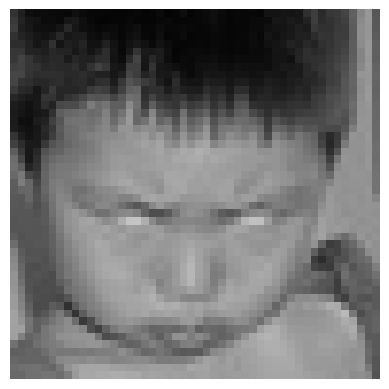

In [12]:
img = cv2.imread('/home/viniciuss/Documents/projetos/FER-2013_emotion_detection/archive/train/angry/Training_10118481.jpg')
plt.imshow(img,'binary')
plt.axis(False)

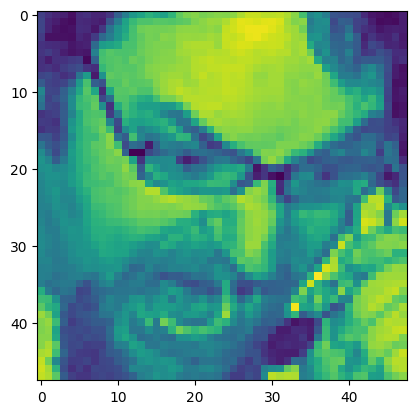

In [5]:
image = cv2.imread('/home/viniciuss/Documents/projetos/FER-2013_emotion_detection/archive/test/angry/PrivateTest_10131363.jpg', 0)
plt.imshow(image)

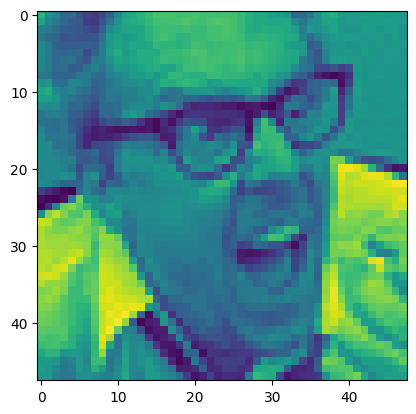

In [6]:
image = cv2.imread('/home/viniciuss/Documents/projetos/FER-2013_emotion_detection/archive/train/angry/Training_3908.jpg', 0)
plt.imshow(image)

In [66]:
## Antes de remover as imagens

In [67]:
for dirpath,dirname,filenames in os.walk('/home/viniciuss/Documents/projetos/FER-2013_emotion_detection/archive'):
    print(f'There are {len(dirname)} directories and {len(filenames)} images in {dirpath}')

There are 2 directories and 0 images in /home/viniciuss/Documents/projetos/FER-2013_emotion_detection/archive
There are 7 directories and 0 images in /home/viniciuss/Documents/projetos/FER-2013_emotion_detection/archive/train
There are 0 directories and 384 images in /home/viniciuss/Documents/projetos/FER-2013_emotion_detection/archive/train/disgust
There are 0 directories and 4852 images in /home/viniciuss/Documents/projetos/FER-2013_emotion_detection/archive/train/neutral
There are 0 directories and 3763 images in /home/viniciuss/Documents/projetos/FER-2013_emotion_detection/archive/train/fear
There are 0 directories and 4444 images in /home/viniciuss/Documents/projetos/FER-2013_emotion_detection/archive/train/sad
There are 0 directories and 3654 images in /home/viniciuss/Documents/projetos/FER-2013_emotion_detection/archive/train/angry
There are 0 directories and 7005 images in /home/viniciuss/Documents/projetos/FER-2013_emotion_detection/archive/train/happy
There are 0 directories 

In [35]:
## Iniciando

In [3]:
# Inicialização do MediaPipe Face Mesh
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=False, max_num_faces=1, min_detection_confidence=0.5)

# Definição dos pontos específicos para a API
points_of_interest = [list(range(10, 14)),  # Lábios
                      list(range(468, 478)),  # Olho esquerdo
                      list(range(249, 259)),  # Olho direito
                      [21, 54, 103, 67, 109, 10, 338, 297, 332, 284, 251],  # Linhas da testa
                      [71, 68, 104, 69, 108, 151, 337, 299, 333, 298, 301, 9],  # Linhas da testa
                      [143, 111, 117, 118, 119, 120, 121, 128, 245],  # Linhas rosto parte direita
                      [214, 207, 205, 36, 142, 126, 217, 174],  # Linhas rosto parte direita
                      [372, 340, 346, 347, 348, 349, 350, 357, 465],  # Linhas rosto parte esquerda
                      [434, 427, 425, 266, 371, 355, 437, 399]  # Linhas rosto parte esquerda
                     ]

I0000 00:00:1719544827.302516   37696 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1719544827.341545   37948 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.183.01), renderer: NVIDIA GeForce GTX 750 Ti/PCIe/SSE2
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1719544827.344388   37944 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1719544827.354281   37940 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


In [4]:
def process_and_save_landmarks(dataset):
    data_dir = '/home/viniciuss/Documents/projetos/FER-2013_emotion_detection/archive'
    dataset_dir = os.path.join(data_dir, dataset)
    processed_data = []

    emotion_to_int = {
        'angry': 0,
        'disgust': 1,
        'fear': 2,
        'happy': 3,
        'sad': 4,
        'surprise': 5,
        'neutral': 6
    }
    
    for emotion_dir in os.listdir(dataset_dir):
        emotion_path = os.path.join(dataset_dir, emotion_dir)
        
        if os.path.isdir(emotion_path):
            image_paths = [os.path.join(emotion_path, f) for f in os.listdir(emotion_path)]
            
            for image_path in image_paths:
                image = cv2.imread(image_path)
                landmarks = extract_landmarks_all(image)
                if landmarks:
                    emotion = emotion_to_int[emotion_dir]
                    processed_data.append({'emotion': emotion, 'landmarks': landmarks})
                else:
                    print(f"Não foi possível extrair landmarks para a imagem: {image_path}")
    
    df = pd.DataFrame(processed_data)
    df.to_parquet(f'{dataset}_landmarks.parquet')
    print(f"Landmarks processados e salvos para {dataset} dataset.")
    return df

In [5]:
data_dir = '/home/viniciuss/Documents/projetos/FER-2013_emotion_detection/archive'

def extract_landmarks_all(image):
    results = face_mesh.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    
    if results.multi_face_landmarks:
        face_landmarks = results.multi_face_landmarks[0]  # Vamos assumir que estamos interessados apenas no primeiro rosto
        landmarks = [(lm.x, lm.y) for lm in face_landmarks.landmark]
        return landmarks
    
    return None

In [6]:
def process_and_save_landmarks(dataset):
    dataset_dir = os.path.join(data_dir, dataset)
    processed_data = []

    emotion_to_int = {
        'angry': 0,
        'disgust': 1,
        'fear': 2,
        'happy': 3,
        'sad': 4,
        'surprise': 5,
        'neutral': 6
    }
    
    for emotion_dir in os.listdir(dataset_dir):
        emotion_path = os.path.join(dataset_dir, emotion_dir)
        
        if os.path.isdir(emotion_path):
            image_paths = [os.path.join(emotion_path, f) for f in os.listdir(emotion_path)]
            
            for image_path in image_paths:
                image = cv2.imread(image_path)
                landmarks = extract_landmarks_all(image)
                if landmarks:
                    emotion = emotion_to_int[emotion_dir]
                    processed_data.append({'emotion': emotion, 'landmarks': landmarks})
                else:
                    print(f"Não foi possível extrair landmarks para a imagem: {image_path}")
    
    df = pd.DataFrame(processed_data)
    df.to_parquet(f'{dataset}_landmarks.parquet')
    print(f"Landmarks processados e salvos para {dataset} dataset.")
    return df

def flatten_landmarks(landmarks):
    return np.array([item for sublist in landmarks for item in sublist])

# Processar e salvar os landmarks para os datasets de treino e teste
train_data = process_and_save_landmarks('train')
test_data = process_and_save_landmarks('test')

# Carregar os dados de landmarks
train_landmarks_df = pd.read_parquet('train_landmarks.parquet')
test_landmarks_df = pd.read_parquet('test_landmarks.parquet')

# Converter landmarks para arrays numpy e flatten os landmarks
X_train = np.array(train_landmarks_df['landmarks'].apply(flatten_landmarks).tolist())
y_train = train_landmarks_df['emotion']

X_test = np.array(test_landmarks_df['landmarks'].apply(flatten_landmarks).tolist())
y_test = test_landmarks_df['emotion']

sample_fraction = 0.1
X_train_sample, _, y_train_sample, _ = train_test_split(X_train, y_train, train_size=sample_fraction, random_state=42)

# Verificar as dimensões dos dados
print(f"Shape de X_train: {X_train.shape}, Shape de y_train: {y_train.shape}")
print(f"Shape de X_test: {X_test.shape}, Shape de y_test: {y_test.shape}")

/home/viniciuss/jupyter-env/lib/python3.12/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


Não foi possível extrair landmarks para a imagem: /home/viniciuss/Documents/projetos/FER-2013_emotion_detection/archive/train/surprise/Training_13005739.jpg
Não foi possível extrair landmarks para a imagem: /home/viniciuss/Documents/projetos/FER-2013_emotion_detection/archive/train/surprise/Training_32183003.jpg
Não foi possível extrair landmarks para a imagem: /home/viniciuss/Documents/projetos/FER-2013_emotion_detection/archive/train/surprise/Training_78744822.jpg
Não foi possível extrair landmarks para a imagem: /home/viniciuss/Documents/projetos/FER-2013_emotion_detection/archive/train/surprise/Training_85087694.jpg
Não foi possível extrair landmarks para a imagem: /home/viniciuss/Documents/projetos/FER-2013_emotion_detection/archive/train/surprise/Training_12700778.jpg
Não foi possível extrair landmarks para a imagem: /home/viniciuss/Documents/projetos/FER-2013_emotion_detection/archive/train/surprise/Training_86145739.jpg
Não foi possível extrair landmarks para a imagem: /home/vi

In [13]:
# Treinar o modelo SVC (gamma, c, kernel)

In [13]:
start_time = time.time()

# Modelo SVC
svc = SVC()
param_grid_svc = {
    'C': [1, 10],  # Reduzido o número de valores para 'C'
    'gamma': [0.01, 0.001],  # Reduzido o número de valores para 'gamma'
    'kernel': ['linear']  # Usando apenas o kernel linear para acelerar
}
grid_search_svc = GridSearchCV(estimator=svc, param_grid=param_grid_svc, cv=3, verbose=2, n_jobs=-1)  # Utilizando n_jobs=-1 para paralelizar
grid_search_svc.fit(X_train_sample, y_train_sample)

# Medir o tempo de fim
end_time = time.time()

# Calcular o tempo total
total_time = end_time - start_time
print(f"Tempo total de treinamento: {total_time / 60:.2f} minutos")

print("Melhores parâmetros encontrados pelo GridSearchCV para SVC:")
print(grid_search_svc.best_params_)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Tempo total de treinamento: 0.51 minutos
Melhores parâmetros encontrados pelo GridSearchCV para SVC:
{'C': 10, 'gamma': 0.01, 'kernel': 'linear'}


In [14]:
# Avaliação do modelo SVC no conjunto de teste
best_svc = grid_search_svc.best_estimator_
y_pred_svc = best_svc.predict(X_test)

# Métricas do modelo
model_metrics = classification_report(y_test, y_pred_svc)
model_cm = confusion_matrix(y_test, y_pred_svc)
model_accuracy = accuracy_score(y_test, y_pred_svc)

print("\nAvaliação do SVC no conjunto de teste:")
print(model_metrics)
print("Matriz de Confusão:")
print(model_cm)
print(f"Acurácia: {model_accuracy:.2f}")


Avaliação do SVC no conjunto de teste:
              precision    recall  f1-score   support

           0       0.34      0.30      0.32       842
           1       0.00      0.00      0.00        97
           2       0.24      0.17      0.20       925
           3       0.68      0.79      0.73      1673
           4       0.41      0.27      0.33      1028
           5       0.59      0.53      0.56       771
           6       0.39      0.60      0.48      1169

    accuracy                           0.48      6505
   macro avg       0.38      0.38      0.37      6505
weighted avg       0.46      0.48      0.46      6505

Matriz de Confusão:
[[ 256    0   78  156   79   44  229]
 [  39    0   21   12    5    2   18]
 [ 117    0  156  146  122  117  267]
 [  67    0   50 1328   61   36  131]
 [ 135    0  134  108  279   33  339]
 [  55    0   97   98   17  410   94]
 [  84    0  105  112  119   49  700]]
Acurácia: 0.48


/home/viniciuss/jupyter-env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/viniciuss/jupyter-env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/viniciuss/jupyter-env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

In [15]:
# Modelo RandomForestClassifier
rfc = RandomForestClassifier(random_state=42)
param_grid_rfc = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20]
}
grid_search_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid_rfc, cv=5, verbose=2)
grid_search_rfc.fit(X_train, y_train)

print("\nMelhores parâmetros encontrados pelo GridSearchCV para RandomForestClassifier:")
print(grid_search_rfc.best_params_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] END ....................max_depth=None, n_estimators=50; total time=  35.7s
[CV] END ....................C=10, gamma=0.01, kernel=linear; total time=  15.7s
[CV] END ....................C=1, gamma=0.001, kernel=linear; total time=  16.1s
[CV] END .....................C=1, gamma=0.01, kernel=linear; total time=  16.4s
[CV] END ....................C=10, gamma=0.01, kernel=linear; total time=  16.2s
[CV] END ....................C=1, gamma=0.001, kernel=linear; total time=  15.6s
[CV] END ...................C=10, gamma=0.001, kernel=linear; total time=   8.3s
[CV] END ....................C=1, gamma=0.001, kernel=linear; total time=  15.4s
[CV] END ...................C=10, gamma=0.001, kernel=linear; total time=   8.8s
[CV] END .....................C=1, gamma=0.01, kernel=linear; total time=  15.4s
[CV] END ....................C=10, gamma=0.01, kernel=linear; total time=   9.0s
[CV] END .....................C=1, gamma=0.01, ke

KeyboardInterrupt: 

In [ ]:
# Avaliação do modelo RandomForestClassifier no conjunto de teste
best_rfc = grid_search_rfc.best_estimator_
y_pred_rfc = best_rfc.predict(X_test)

# Métricas do modelo
model_metrics_rfc = classification_report(y_test, y_pred_rfc)
model_cm_rfc = confusion_matrix(y_test, y_pred_rfc)
model_accuracy_rfc = best_rfc.score(X_test, y_test)

print("\nAvaliação do RandomForestClassifier no conjunto de teste:")
print(model_metrics_rfc)
print("Matriz de Confusão:")
print(model_cm_rfc)
print(f"Acurácia: {model_accuracy_rfc:.2f}")

In [7]:
# Carregar os landmarks do conjunto de treinamento
train_landmarks_df = pd.read_parquet('train_landmarks.parquet')

# Exibir informações básicas sobre os dados
print('Primeiras linhas do DataFrame:')
print(train_landmarks_df.head())

print('\nTamanho do DataFrame:')
print(train_landmarks_df.shape)

print('\nVerificar se há valores ausentes:')
print(train_landmarks_df.isnull().sum())

# Exemplo de landmarks para análise
example_landmarks = train_landmarks_df.iloc[0, :-1].values  # Excluir a última coluna que contém as labels

print('\nVerificar o intervalo dos valores de landmarks faciais:')
print(f"Valores mínimos: {example_landmarks.min()}")
print(f"Valores máximos: {example_landmarks.max()}")

Primeiras linhas do DataFrame:
   emotion                                          landmarks
0        5  [[0.49398499727249146, 0.6353805065155029], [0...
1        5  [[0.39318913221359253, 0.7010979056358337], [0...
2        5  [[0.5134940147399902, 0.7652460932731628], [0....
3        5  [[0.472968190908432, 0.7182454466819763], [0.4...
4        5  [[0.19630539417266846, 0.7481423616409302], [0...

Tamanho do DataFrame:
(26030, 2)

Verificar se há valores ausentes:
emotion      0
landmarks    0
dtype: int64

Verificar o intervalo dos valores de landmarks faciais:
Valores mínimos: 5
Valores máximos: 5


In [8]:
# Carregar os landmarks do conjunto de teste
test_landmarks_df = pd.read_parquet('test_landmarks.parquet')

# Exibir informações básicas sobre os dados
print('Primeiras linhas do DataFrame:')
print(test_landmarks_df.head())

print('\nTamanho do DataFrame:')
print(test_landmarks_df.shape)

print('\nVerificar se há valores ausentes:')
print(test_landmarks_df.isnull().sum())

# Exemplo de landmarks para análise
example_landmarks = test_landmarks_df.iloc[0, :-1].values  # Excluir a última coluna que contém as labels

print('\nVerificar o intervalo dos valores de landmarks faciais:')
print(f"Valores mínimos: {example_landmarks.min()}")
print(f"Valores máximos: {example_landmarks.max()}")

Primeiras linhas do DataFrame:
   emotion                                          landmarks
0        5  [[0.4713827967643738, 0.6366324424743652], [0....
1        5  [[0.48339179158210754, 0.7417855262756348], [0...
2        5  [[0.41860124468803406, 0.5809292197227478], [0...
3        5  [[0.4892858862876892, 0.7372030019760132], [0....
4        5  [[0.3499050736427307, 0.664393424987793], [0.2...

Tamanho do DataFrame:
(6505, 2)

Verificar se há valores ausentes:
emotion      0
landmarks    0
dtype: int64

Verificar o intervalo dos valores de landmarks faciais:
Valores mínimos: 5
Valores máximos: 5


In [38]:
# Inicializar o detector de face da MediaPipe
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1)

image_name = 'PrivateTest_10131363.jpg'
image_path = os.path.join(test_dir, 'angry', image_name)
image = cv2.imread(image_path)

if image is None:
    print(f"Não foi possível carregar a imagem {image_name}.")
else:
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = face_mesh.process(image_rgb)
    
    if results.multi_face_landmarks:
        face_landmarks = results.multi_face_landmarks[0]
        
        mp_drawing = mp.solutions.drawing_utils
        mp_drawing.draw_landmarks(
            image=image,
            landmark_list=face_landmarks,
            connections=mp_face_mesh.FACEMESH_CONTOURS,
            landmark_drawing_spec=mp_drawing.DrawingSpec(color=(0, 255, 0), thickness=1, circle_radius=1),
            connection_drawing_spec=mp_drawing.DrawingSpec(color=(0, 255, 0), thickness=1)
        )
        
        # Criar uma janela com um nome específico
        cv2.namedWindow("Face Landmarks", cv2.WINDOW_NORMAL)
        
        # Redimensionar a janela para um tamanho maior
        #cv2.resizeWindow("Face Landmarks", 800, 600)
        
        cv2.imshow("Face Landmarks", image)
        
        # Aguardar até que a tecla 'q' seja pressionada
        while True:
            key = cv2.waitKey(1) & 0xFF
            if key == ord('q'):
                break
        
        cv2.destroyAllWindows()
    else:
        print(f"Nenhum rosto detectado na imagem {image_name}.")

I0000 00:00:1719495703.684588   35040 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1719495703.685863   37271 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.2), renderer: Mesa Intel(R) UHD Graphics (TGL GT1)
W0000 00:00:1719495703.687898   37262 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1719495703.692323   37261 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
/home/viniciuss/.local/lib/python3.10/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
